# 00. Network preprocessing, single study area
## Project: Bicycle node network loop analysis

This notebook preprocesses the network data from a single study area (*not* whole Denmark) and saves an intermediate format.  
Please select an appropriate study area in the `config.yml` (*not* `denmark`).  

The steps are:
- Take largest component
- Simplify: Drop self-loops, dangling nodes, degree 2 nodes

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2024-10-01  
Last modified: 2025-09-10

## Parameters

In [1]:
%run -i setup_parameters.py
debug = True  # Set to True for extra plots and verbosity

## Functions

In [2]:
%run -i functions.py

## Processing data

### Load data

In [3]:
PATH

{'parameters': '../parameters/',
 'data_in_network': '../data/input/bornholm/network/processed/',
 'data_in_pois': '../data/input/bornholm/point/',
 'data_out': '../data/processed/bornholm/',
 'plot': '../plots/bornholm/',
 'bornholm': {'data_in_network': '../data/input/bornholm/network/processed/',
  'data_in_pois': '../data/input/bornholm/point/',
  'data_out': '../data/processed/bornholm/',
  'plot': '../plots/bornholm/'}}

In [4]:
edges = gpd.read_file(PATH["data_in_network"] + "edges_slope.gpkg")
edges_orig = edges  # Make a deep copy to save the geometries
edges["edge_id"] = edges.index  # Make index the edge id
if not MAXSLOPES_AVAILABLE:  # Generate random data if max_slopes not available
    edges["max_slope"] = np.random.normal(2, 2, edges.shape[0]).clip(
        min=0
    ) + np.random.rand(edges.shape[0])
nodes = gpd.read_file(PATH["data_in_network"] + "nodes.gpkg")
# Set CRS
edges.set_crs(epsg=25832, inplace=True)
nodes.set_crs(epsg=25832, inplace=True);

In [5]:
if debug:
    print(edges.head())

        mm_len  node_start  node_end  edge_id  min_slope  max_slope  \
0  4070.941878           0         1        0   0.003704   3.750957   
1  5059.992235           0         2        1   0.015633   4.673647   
2  3526.484593           0         3        2   0.035969   4.319620   
3  3894.576779           1         4        3   0.037268   2.770777   
4  9627.531989           1        11        4   0.004103   2.348074   

   ave_slope                                           geometry  
0   0.640971  LINESTRING (884790.176 6111667.992, 884809.13 ...  
1   0.782629  LINESTRING (881658.93 6114106.8, 881668.7 6114...  
2   0.991292  LINESTRING (884790.176 6111667.992, 884790.75 ...  
3   0.749578  LINESTRING (886896.12 6114528.37, 886899.6 611...  
4   0.548400  LINESTRING (888758.8 6112075.84, 888772.57 611...  


In [6]:
if debug:
    print(nodes.head())

   nodeID id_cykelknudepkt                        geometry
0       0       ['vk2605']  POINT (884790.176 6111667.992)
1       1       ['vk2756']     POINT (888758.8 6112075.84)
2       2       ['vk2556']     POINT (881658.93 6114106.8)
3       3       ['vk2753']    POINT (885859.66 6114266.65)
4       4       ['vk2755']    POINT (886896.12 6114528.37)


In [7]:
nodes_id = list(nodes.nodeID)
nodes_x = list(nodes.geometry.x)
nodes_y = list(nodes.geometry.y)
nodes_coords = list(zip(normalize_data(nodes_x), normalize_data(nodes_y)))

In [8]:
# Rename mm_len to weight for igraph
edges = edges.rename(columns={"mm_len": "weight"})
# Drop unused columns
used_columns = {
    "node_start": (),
    "node_end": (),
    "weight": (),
    "edge_id": (),
    "max_slope": (),
    "geometry": (),
}
for c_name, _ in edges.items():
    if c_name not in used_columns:
        del edges[c_name]

# Reorder columns
edges = edges[["node_start", "node_end", "weight", "edge_id", "max_slope", "geometry"]]
edges = edges.dropna()  # Drop edges with None node_start or node_end
edges.head()

,node_start,node_end,weight,edge_id,max_slope,geometry
0,0,1,4070.941878,0,3.750957,"LINESTRING (884790.176 6111667.992, 884809.13 ..."
1,0,2,5059.992235,1,4.673647,"LINESTRING (881658.93 6114106.8, 881668.7 6114..."
2,0,3,3526.484593,2,4.319620,"LINESTRING (884790.176 6111667.992, 884790.75 ..."
3,1,4,3894.576779,3,2.770777,"LINESTRING (886896.12 6114528.37, 886899.6 611..."
4,1,11,9627.531989,4,2.348074,"LINESTRING (888758.8 6112075.84, 888772.57 611..."


### Turn into igraph object

In [9]:
G = ig.Graph.TupleList(
    edges.itertuples(index=False),
    directed=False,
    weights=False,
    edge_attrs=["weight", "edge_id", "max_slope", "geometry"],
)
if STUDY_AREA == "bornholm":
    delta = BORNHOLM_DELTA
    for e in G.es:  # translate edges, below nodes
        G.es[e.index]["geometry"] = gpd.GeoSeries(G.es[e.index]["geometry"]).translate(
            xoff=delta[0], yoff=delta[1]
        )[0]
else:
    delta = [0, 0]
for v in G.vs:  # Add node infos: id_cykelknudepkt, x, y
    G.vs[v.index]["id_cykelknudepkt"] = nodes.loc[nodes["nodeID"] == v["name"]].iloc[0][
        "id_cykelknudepkt"
    ]
    G.vs[v.index]["x"] = round(
        nodes.loc[nodes["nodeID"] == v["name"]].iloc[0].geometry.x + delta[0], 3
    )
    G.vs[v.index]["y"] = round(
        nodes.loc[nodes["nodeID"] == v["name"]].iloc[0].geometry.y + delta[1], 3
    )
degreedistrib_to_csv(Counter(G.degree()), PATH["data_out"] + "degreedistrib_pre.csv")

In [10]:
if debug:
    for e in G.es[:10]:
        print(e)
G.summary()

igraph.Edge(<igraph.Graph object at 0x17ba94c50>, 0, {'weight': 4070.9418783009255, 'edge_id': 0, 'max_slope': 3.75095653534254, 'geometry': <LINESTRING (664790.176 6231667.992, 664809.13 6231671.23, 664830.26 6231674...>})
igraph.Edge(<igraph.Graph object at 0x17ba94c50>, 1, {'weight': 5059.99223509078, 'edge_id': 1, 'max_slope': 4.673646926889586, 'geometry': <LINESTRING (661658.93 6234106.8, 661668.7 6234101.93, 661683.216 6234094.96...>})
igraph.Edge(<igraph.Graph object at 0x17ba94c50>, 2, {'weight': 3526.4845931408404, 'edge_id': 2, 'max_slope': 4.319620132431347, 'geometry': <LINESTRING (664790.176 6231667.992, 664790.75 6231674.42, 664790.024 623168...>})
igraph.Edge(<igraph.Graph object at 0x17ba94c50>, 3, {'weight': 3894.5767788336257, 'edge_id': 3, 'max_slope': 2.770776748651723, 'geometry': <LINESTRING (666896.12 6234528.37, 666899.6 6234512.98, 666912.24 6234478.04...>})
igraph.Edge(<igraph.Graph object at 0x17ba94c50>, 4, {'weight': 9627.531988635823, 'edge_id': 4, 'max_s

'IGRAPH UNW- 59 89 -- \n+ attr: id_cykelknudepkt (v), name (v), x (v), y (v), edge_id (e), geometry (e), max_slope (e), weight (e)'

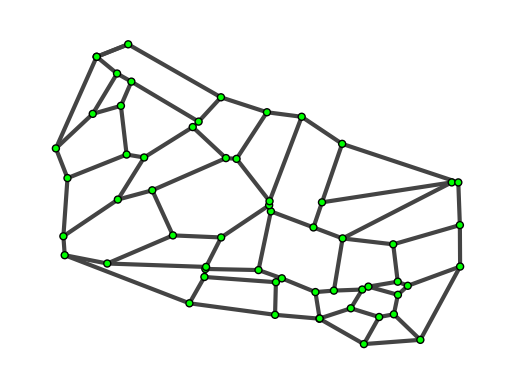

In [11]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Take largest connected component

In [12]:
components = G.connected_components()
memberships = np.unique(components.membership, return_counts=True)
index_gcc = memberships[0][
    memberships[1].argmax(axis=0)
]  # get index of component with most nodes
G = G.subgraph(components[index_gcc])

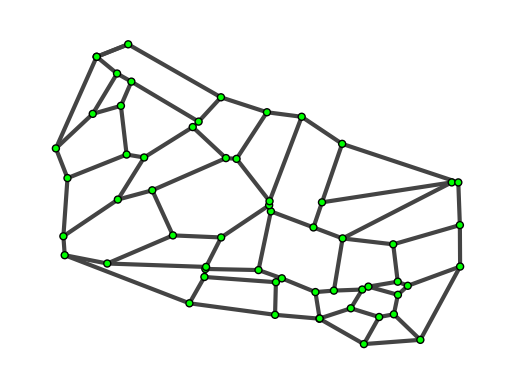

In [13]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Drop self-loops

They can be dangling links which go outside the region which were mistakenly connected to themselves.

In [14]:
G.simplify(
    multiple=True,
    loops=True,
    combine_edges=dict(weight=min, max_slope=max, edge_id=min, geometry="first"),
);

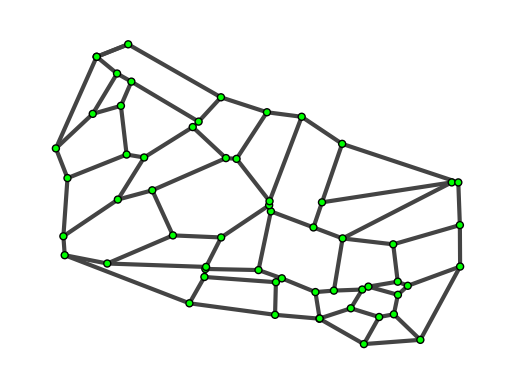

In [15]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Drop dangling nodes

In [16]:
# Source: https://codereview.stackexchange.com/questions/284246/deletion-of-nodes-of-degree-1-from-a-python-igraph-graph
vertices = {v for v in G.vs.select(_degree_le=1)}
needs_to_be_checked = set(vertices)
while needs_to_be_checked:
    vertex = needs_to_be_checked.pop()
    for n_vertex in vertex.neighbors():
        if (
            n_vertex in vertices
            or sum(1 for v in n_vertex.neighbors() if v not in vertices) > 1
        ):
            continue
        vertices.add(n_vertex)
        needs_to_be_checked.add(n_vertex)
G.delete_vertices(vertices)

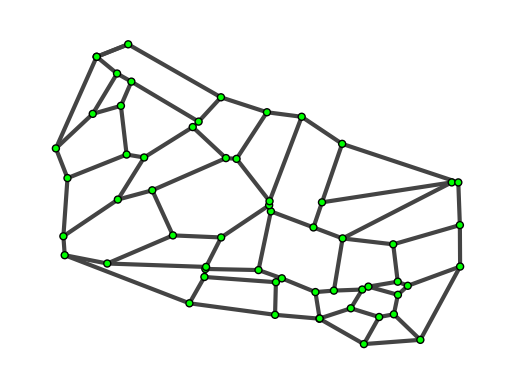

In [17]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Drop degree 2 nodes

In [18]:
to_delete_ids = []

# Unclear how to select nodes in igraph by name, so let's iterate through them
for v in G.vs:
    if v.degree() == 2:
        # Remember node to delete
        to_delete_ids.append(v.index)
        # Add a new edge that combines the deleted ones
        sumoflengths = (
            v.incident()[0].attributes()["weight"]
            + v.incident()[1].attributes()["weight"]
        )
        maxofslopes = max(
            [
                v.incident()[0].attributes()["max_slope"],
                v.incident()[1].attributes()["max_slope"],
            ]
        )
        both_edges = shapely.geometry.MultiLineString(
            [
                v.incident()[0].attributes()["geometry"],
                v.incident()[1].attributes()["geometry"],
            ]
        )
        G.add_edge(
            v.neighbors()[0].index,
            v.neighbors()[1].index,
            weight=sumoflengths,
            max_slope=maxofslopes,
            edge_id=v.incident()[0].attributes()["edge_id"],
            geometry=shapely.line_merge(both_edges),
        )
G.delete_vertices(to_delete_ids)

# Re-simplify
G.simplify(
    multiple=True,
    loops=True,
    combine_edges=dict(weight=min, edge_id=min, max_slope=max, geometry="first"),
);

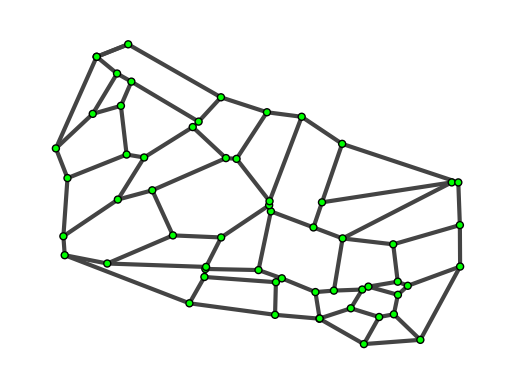

In [19]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Re-Drop dangling nodes

In [20]:
# Source: https://codereview.stackexchange.com/questions/284246/deletion-of-nodes-of-degree-1-from-a-python-igraph-graph
vertices = {v for v in G.vs.select(_degree_le=1)}
needs_to_be_checked = set(vertices)
while needs_to_be_checked:
    vertex = needs_to_be_checked.pop()
    for n_vertex in vertex.neighbors():
        if (
            n_vertex in vertices
            or sum(1 for v in n_vertex.neighbors() if v not in vertices) > 1
        ):
            continue
        vertices.add(n_vertex)
        needs_to_be_checked.add(n_vertex)
G.delete_vertices(vertices)

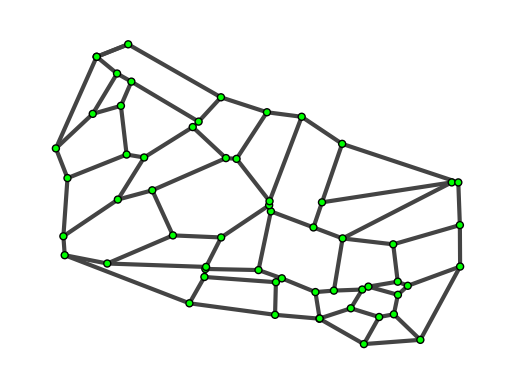

In [21]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

### Re-take largest connected component

In [22]:
components = G.connected_components()
memberships = np.unique(components.membership, return_counts=True)
index_gcc = memberships[0][
    memberships[1].argmax(axis=0)
]  # get index of component with most nodes
G = G.subgraph(components[index_gcc])

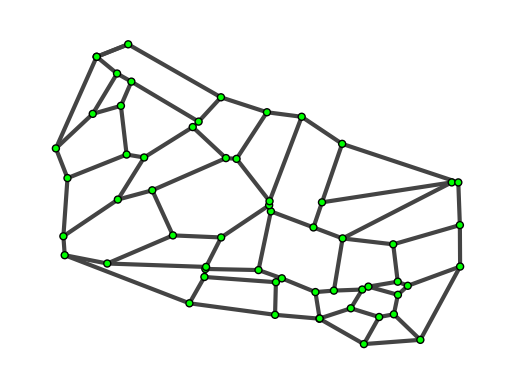

In [23]:
# Plot to double-check
if debug:
    plot_check(
        G,
        nodes_id,
        nodes_coords,
        vertex_size=get_vertex_size_constant(G.vcount()),
        edge_width=get_edgewidth_constant(G.ecount()),
    )

## Save preprocessed network data

In [24]:
G.summary()

'IGRAPH UNW- 59 89 -- \n+ attr: id_cykelknudepkt (v), name (v), x (v), y (v), edge_id (e), geometry (e), max_slope (e), weight (e)'

In [25]:
degreedistrib_to_csv(Counter(G.degree()), PATH["data_out"] + "degreedistrib_post.csv")

In [26]:
with lzma.open(PATH["data_out"] + "network_preprocessed0.xz", "wb") as f:
    pickle.dump(G, f)